# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [1]:
import librosa
import numpy as np
import tensorflow as tf
import mir_eval
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, Reduction
import sscs

2023-06-25 23:29:09.582947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-25 23:29:09.583084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-25 23:29:09.583218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-25 23:29:09.683996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 23:29:17,133	INFO worker.py:1636 -- Sta

## 2 - Download and extract dataset SSCS

In [2]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [3]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

2023-06-25 23:29:19.448076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 23:29:19.505422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 23:29:19.505482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 23:29:19.510706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 23:29:19.510796: I tensorflow/compile

In [4]:
voas_cnn = sscs.res_voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=2e-3),
                 loss=BinaryCrossentropy(reduction=Reduction.SUM_OVER_BATCH_SIZE),
                 metrics=[sscs.f1])

#print(voas_cnn.summary())

sscs.load_weights(voas_cnn)
sscs.train(voas_cnn, ds_train, ds_val)       

## 4 - Playground

1/1 [==============================] - 0s 493ms/step
0.9994419642857143 0.9994419642857143 0.9988845510317903 0.9994419642857143


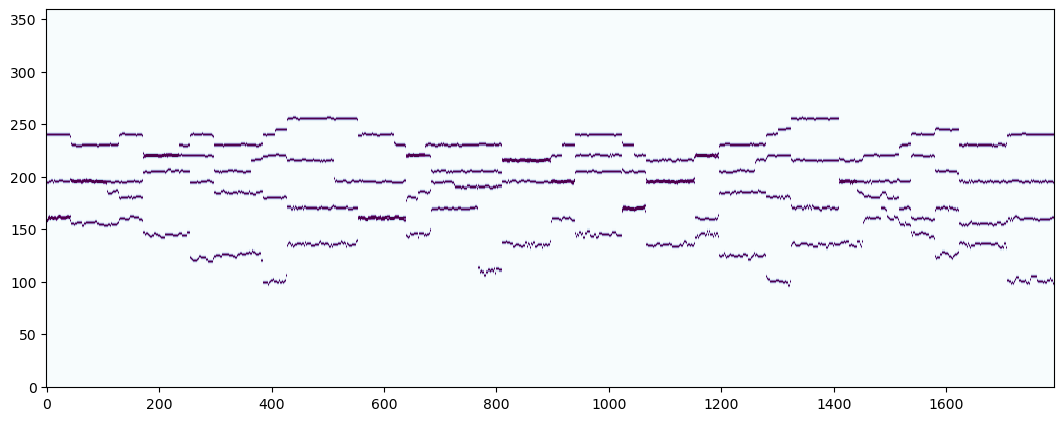

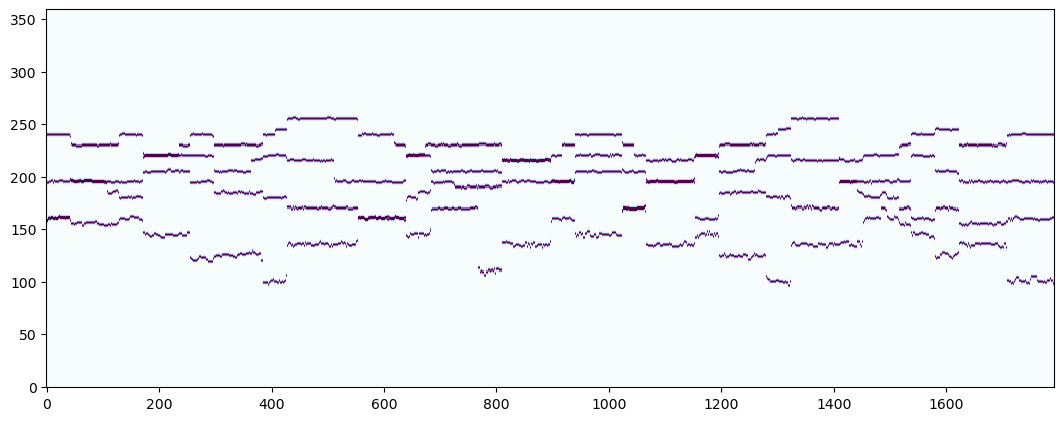

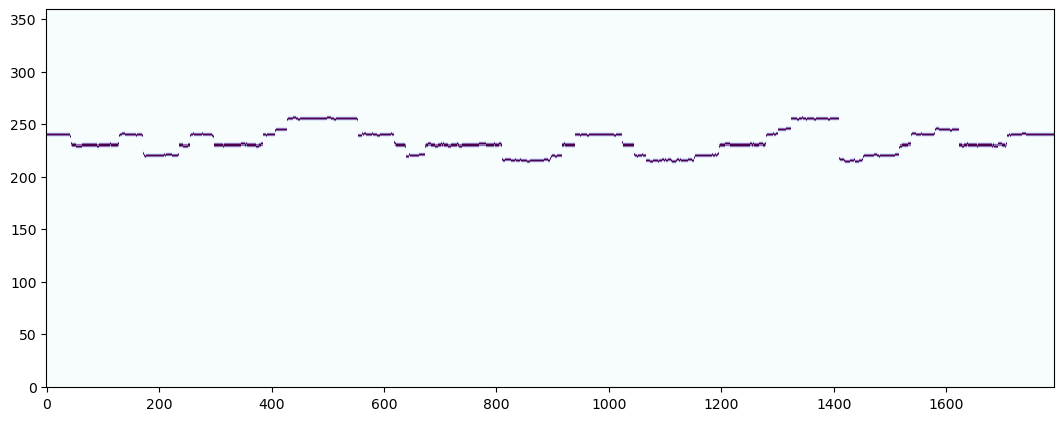

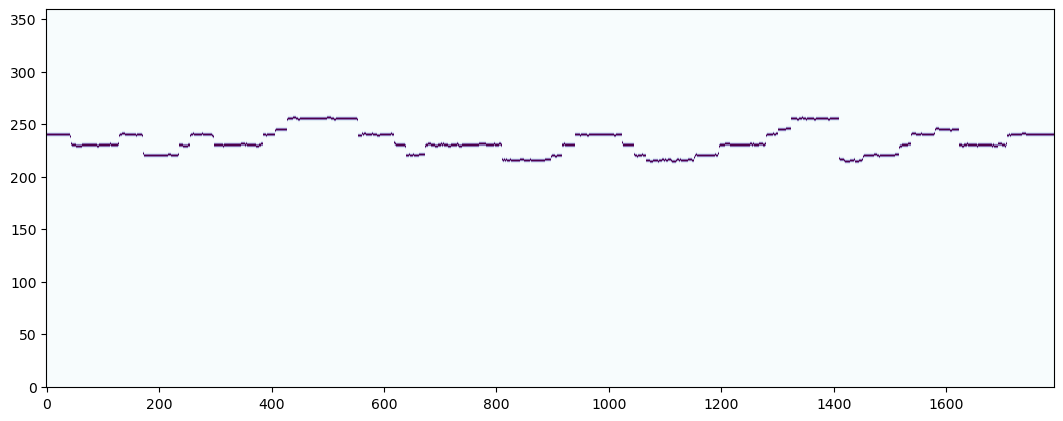

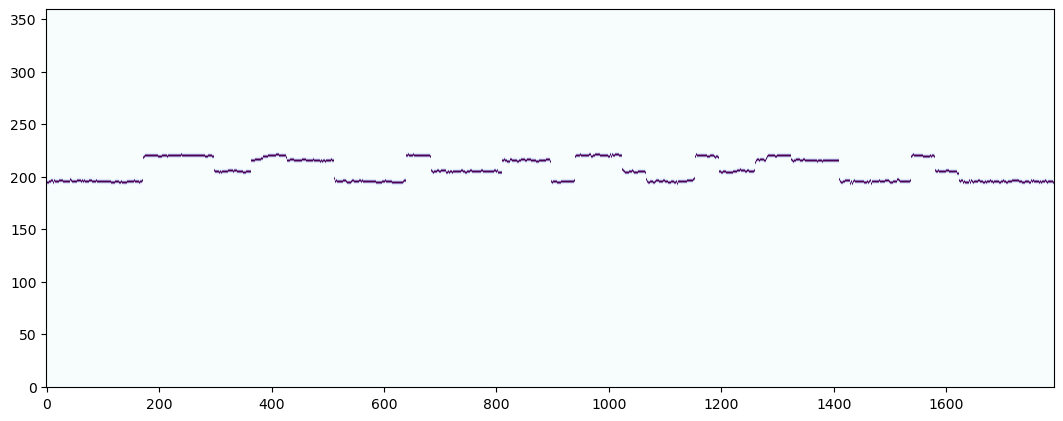

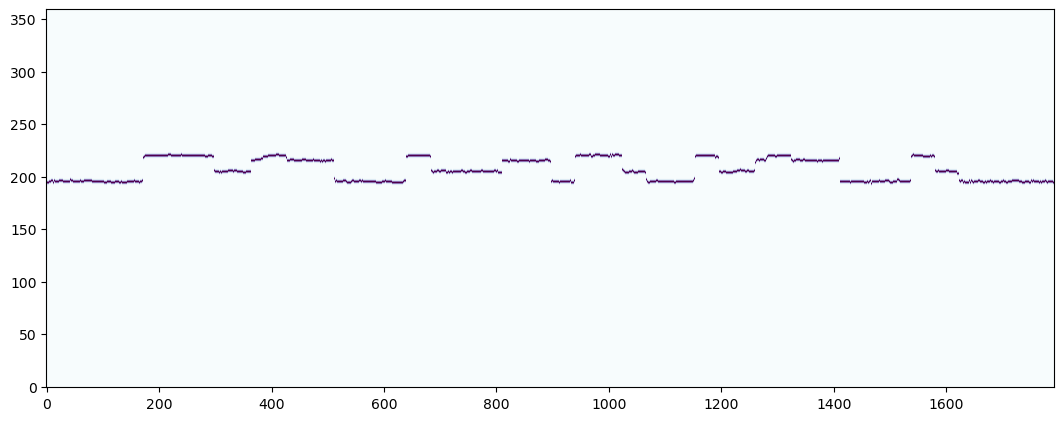

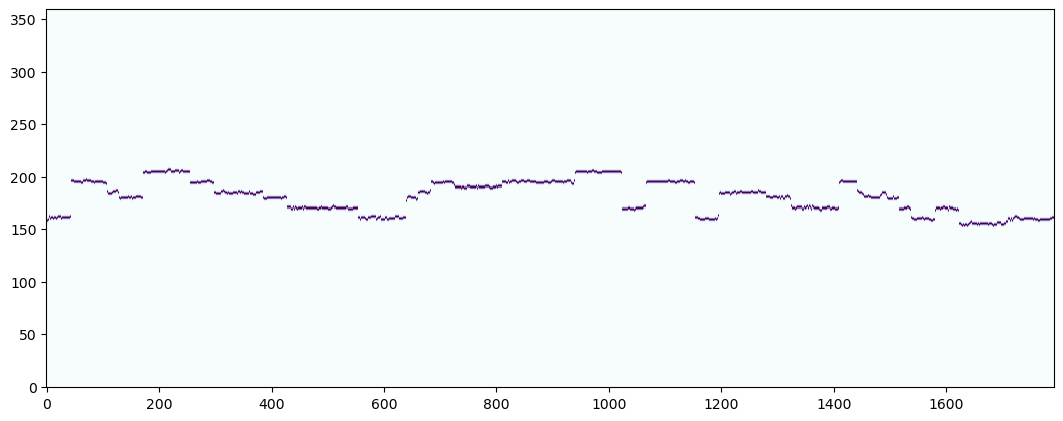

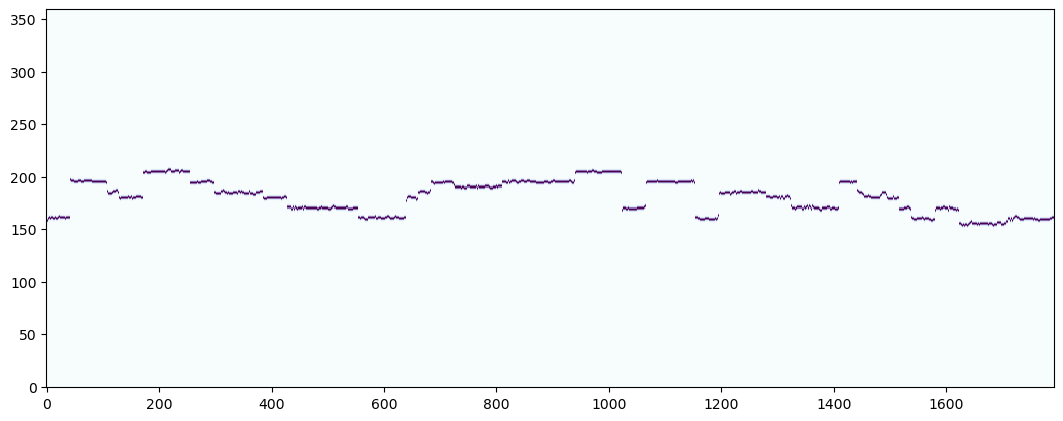

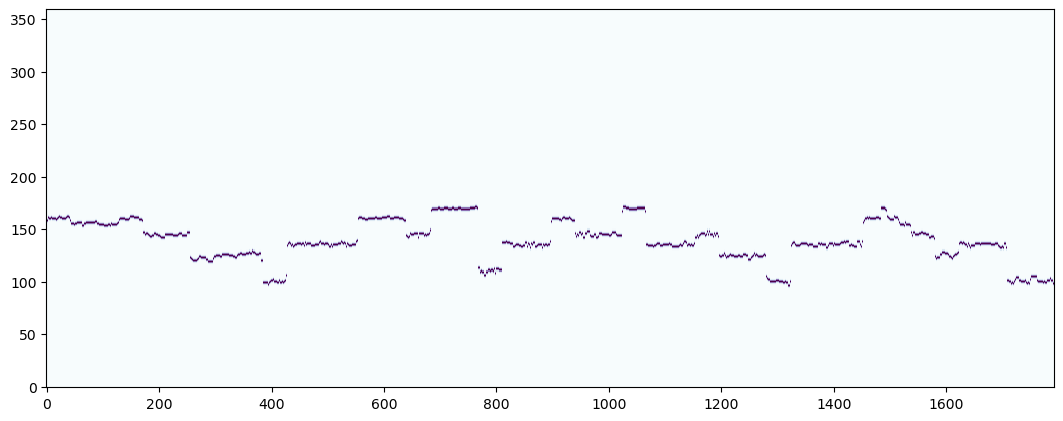

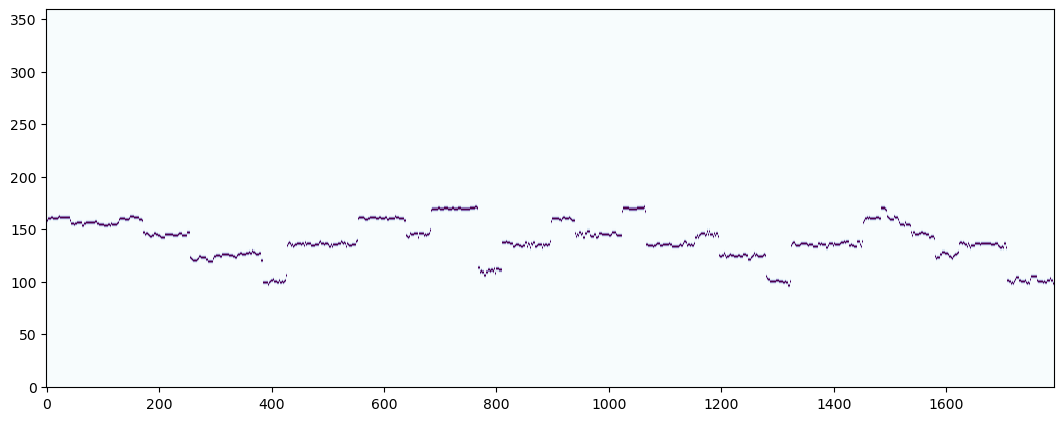

In [9]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

timescale = np.arange(0, 0.011 * mix.shape[1], 0.011)
freqscale = librosa.cqt_frequencies(n_bins=360, fmin=32.7, bins_per_octave=60)

def bin_to_freq(bin):
    return freqscale[bin]

vec_bin_to_freq = np.vectorize(bin_to_freq)

s_true_argmax = np.argmax(s, axis=0)
s_pred_argmax = np.argmax(s_pred_postproc, axis=0)

s_true_freqs = vec_bin_to_freq(s_true_argmax).reshape(-1, 1)
s_pred_freqs = vec_bin_to_freq(s_pred_argmax).reshape(-1, 1)

mir_eval.multipitch.validate(timescale, s_true_freqs, timescale, s_pred_freqs)

metrics = mir_eval.multipitch.metrics(timescale, s_true_freqs, timescale, s_pred_freqs)
f1_score = sscs.f1_prec_rec(metrics[0], metrics[1])
print(metrics[0], metrics[1], metrics[2], f1_score)

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')